In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_recall_curve, f1_score

In [ ]:
# import pandas as pd
# import numpy as np

# # Paramètres pour la simulation
# np.random.seed(42)  # Pour reproductibilité
# n_samples = 1000

# # Générer des données simulées
# data = {
#     'heures_fonctionnement': np.random.normal(500, 100, n_samples),  # Moyenne 500h, écart-type 100
#     'vibrations': np.random.normal(0.5, 0.1, n_samples),  # Moyenne 0.5, écart-type 0.1
#     'temperature': np.random.normal(70, 10, n_samples),  # Moyenne 70°C, écart-type 10
#     'panne': np.random.choice([0, 1], n_samples, p=[0.9, 0.1])  # 10% de pannes
# }

# # Créer un DataFrame
# df = pd.DataFrame(data)

# # Sauvegarder les données pour référence
# df.to_csv('equipement_data.csv', index=False)


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Importance des variables
# plt.figure(figsize=(8, 6))
# sns.barplot(x=model.feature_importances_, y=X.columns)
# plt.title('Importance des variables dans la prédiction des pannes')
# plt.xlabel('Importance')
# plt.ylabel('Variable')
# plt.savefig('importance_variables.png')
# plt.close()

# # Prédiction sur de nouvelles données
# new_data = pd.DataFrame({
#     'heures_fonctionnement': [600],
#     'vibrations': [0.6],
#     'temperature': [75]
# })
# new_data_scaled = scaler.transform(new_data)
# prediction = model.predict_proba(new_data_scaled)[:, 1]
# print(f"Probabilité de panne pour le nouvel équipement : {prediction[0]:.2%}")

In [ ]:

# Charger le dataset (remplace 'path_to_dataset' par le chemin de ton fichier CSV)
df = pd.read_csv('predictive_maintenance.csv')


In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [ ]:
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

In [ ]:
df['Failure Type'].unique()

In [ ]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [ ]:
cols_exclu = ['UDI', 'Target']
col_num = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in cols_exclu]
df1 = df[col_num]

In [ ]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [ ]:
moy = df[col_num].mean().to_list()
ecart_type = df[col_num].std().to_list()

In [ ]:
moy, ecart_type

([300.00493, 310.00556, 1538.7761, 39.986909999999995, 107.951],
 [2.000258682915751,
  1.4837342191657208,
  179.2840959134266,
  9.968933725121337,
  63.654146636636355])

In [ ]:
print(df.columns)

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')


In [ ]:
cols_exclu = ['UDI', 'Target']
col_num = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in cols_exclu]
scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

y = df['Target']
X = df.drop(['UDI','Product ID', 'Failure Type', 'Target', 'Type'], axis=1)
X.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(' ', '_') for col in X.columns]


# Encoder la variable catégorique 'product_quality'
# X = pd.get_dummies(X, columns=['Type'], drop_first=True)


# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((8000, 5), (2000, 5))

In [ ]:
# corr_matrix = train_df.corr()

In [ ]:
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', {0:1, 1:20}],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 9],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    },
    "KNeighborsClassifier" : {
        "n_neighbors": np.arange(1,20) ,
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan', 'minkowski'],
        "p": [1, 2]
    }
}

In [ ]:
# Définir les modèles
from xgboost import XGBClassifier


models = {
        "KNeighborsClassifier": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [ ]:
# # GridSearchCV pour chaque modèle
# best_models = {}
# for name, model in models.items():
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     grid = GridSearchCV(model, param_grids[name], cv=skf, n_jobs=-1)
#     grid.fit(X_train, y_train)
#     best_models[name] = grid.best_estimator_
    
#     print(f" Meilleurs paramètres pour {name} : {grid.best_params_}")

In [ ]:
# Sauvegarder le modèle et le scaler
# joblib.dump(grid, 'grid_complet.pkl_grid')

In [ ]:
grid_charger = joblib.load('grid_complet.pkl_grid')

In [ ]:
model_xgb = grid_charger.best_estimator_

In [ ]:


# GridSearchCV pour maximiser le recall
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10],
#     'min_samples_split': [2, 5],
#     'class_weight': ['balanced', {0:1, 1:20}]
# }
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     scoring='recall',
#     cv=skf,
#     n_jobs=-1
# )
# grid.fit(X_train, y_train)
# model = grid.best_estimator_


In [ ]:
# model = RandomForestClassifier(random_state=42, class_weight='balanced')

In [ ]:
def evaluate(model, nome_model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    # cv = ShuffleSplit(5, test_size=0.2)
    cv = StratifiedKFold(5)
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=cv, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='val_score')
    plt.title(nome_model)
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [ ]:
mmodel = XGBClassifier(random_state=42)

[[1932    7]
 [  22   39]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.85      0.64      0.73        61

    accuracy                           0.99      2000
   macro avg       0.92      0.82      0.86      2000
weighted avg       0.98      0.99      0.98      2000



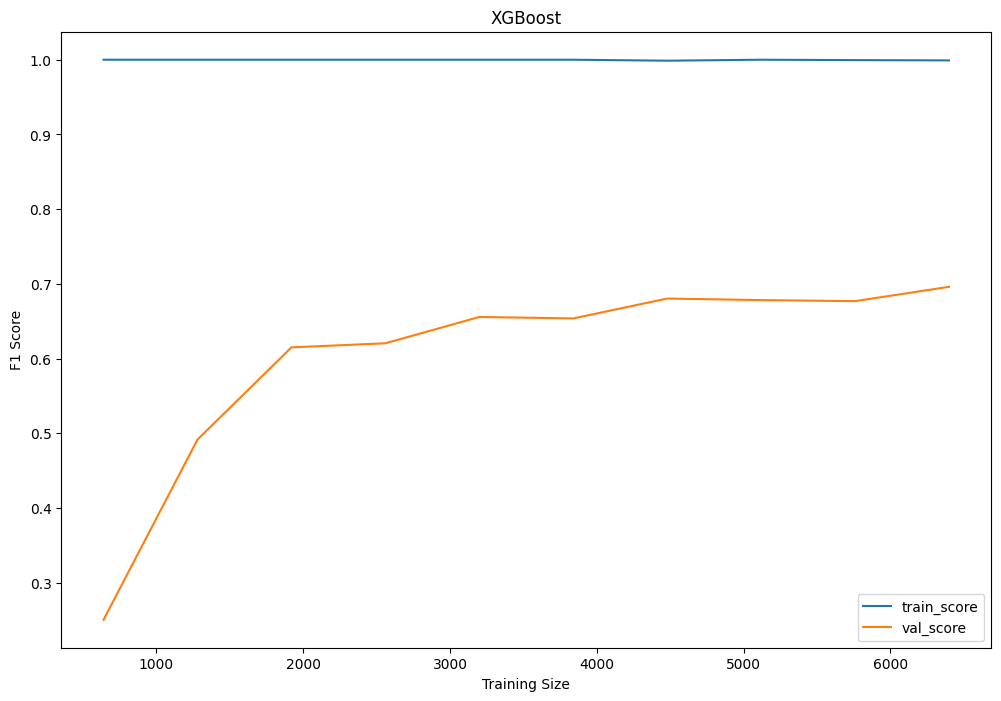

In [ ]:
evaluate(mmodel, 'XGBoost')

In [ ]:
moodel = RandomForestClassifier(random_state=42)

[[1931    8]
 [  25   36]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.82      0.59      0.69        61

    accuracy                           0.98      2000
   macro avg       0.90      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000



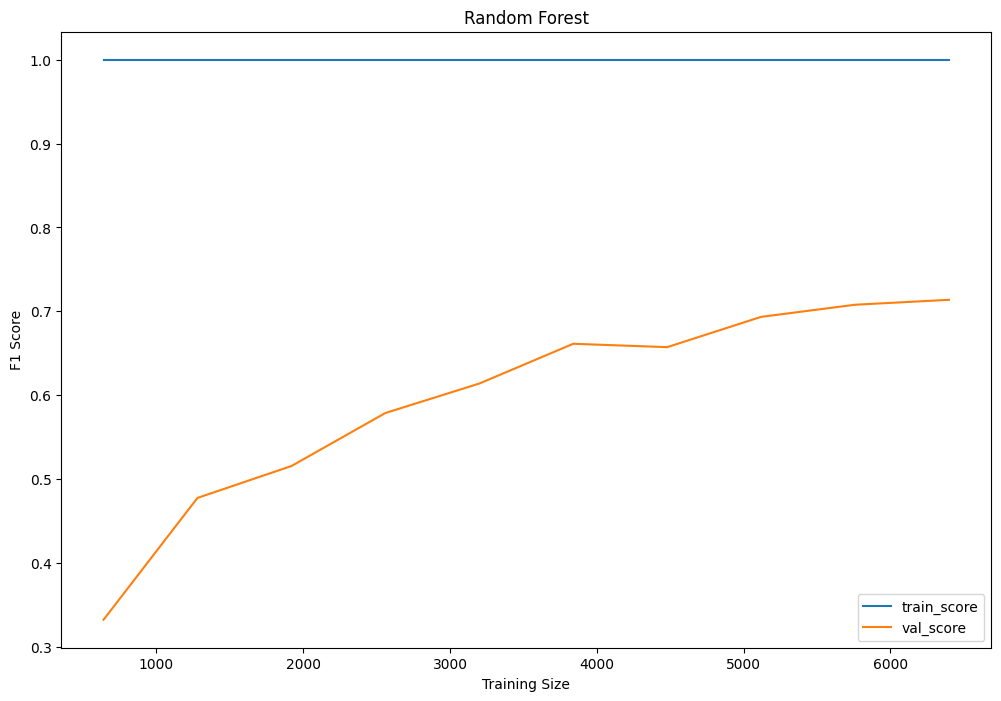

In [ ]:
evaluate(moodel, "Random Forest")

In [ ]:
# for name, model in best_models.items():
#     print(f"\n>>> {name}")
#     evaluate(model, name)


>>> xgboost
[[1929   10]
 [  20   41]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.80      0.67      0.73        61

    accuracy                           0.98      2000
   macro avg       0.90      0.83      0.86      2000
weighted avg       0.98      0.98      0.98      2000



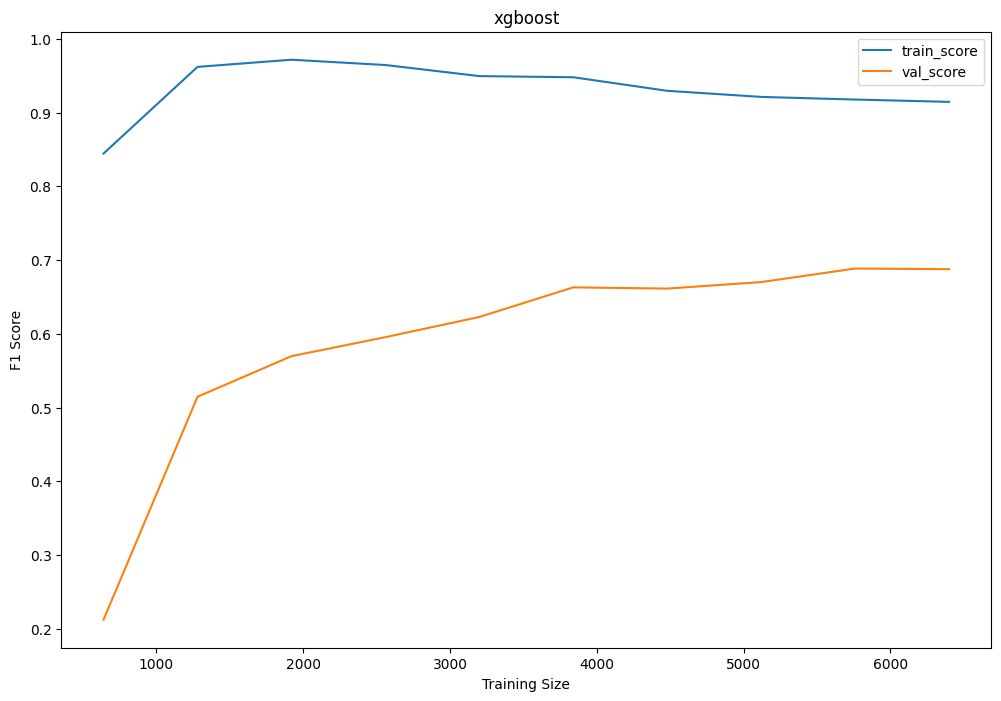

In [ ]:
print(f"\n>>> {'xgboost'}")
evaluate(model_xgb, 'xgboost')

In [ ]:
# # Sauvegarder le modèle et le scaler
# joblib.dump(model, 'model_rf.pkl_grid')
# joblib.dump(scaler, 'scaler.pkl')

In [ ]:
# Prédictions des probabilités
y_probs = model_xgb.predict_proba(X_test)[:, 1]

In [ ]:
# Calculer la courbe précision-rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

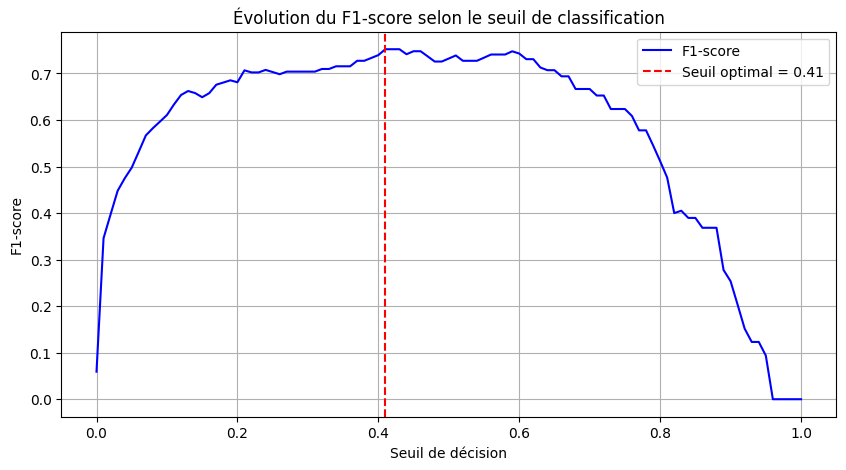

In [ ]:
# 5. Chercher le meilleur seuil
seuils = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_test, y_probs > s) for s in seuils]
seuil_optimal = seuils[np.argmax(f1_scores)]

# 6. Afficher les résultats
plt.figure(figsize=(10,5))
plt.plot(seuils, f1_scores, label="F1-score", color='blue')
plt.axvline(seuil_optimal, color='red', linestyle='--', label=f"Seuil optimal = {seuil_optimal:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("F1-score")
plt.title("Évolution du F1-score selon le seuil de classification")
plt.legend()
plt.grid(True)
plt.show()

# 7. Prédictions avec ce seuil
y_pred_final = (y_probs > seuil_optimal).astype(int)

In [ ]:
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

[[1927   12]
 [  17   44]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.79      0.72      0.75        61

    accuracy                           0.99      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.98      0.99      0.99      2000



In [ ]:
# # Visualiser la courbe précision-rappel
# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, marker='.')
# plt.scatter(recall[optimal_idx], precision[optimal_idx], color='red', label=f'Seuil = {optimal_threshold:.2f}')
# plt.xlabel('Recall')
# plt.ylabel('Précision')
# plt.title('Courbe Précision-Rappel')
# plt.legend()
# plt.grid(True)
# plt.savefig('precision_recall_curve.png')
# plt.show()

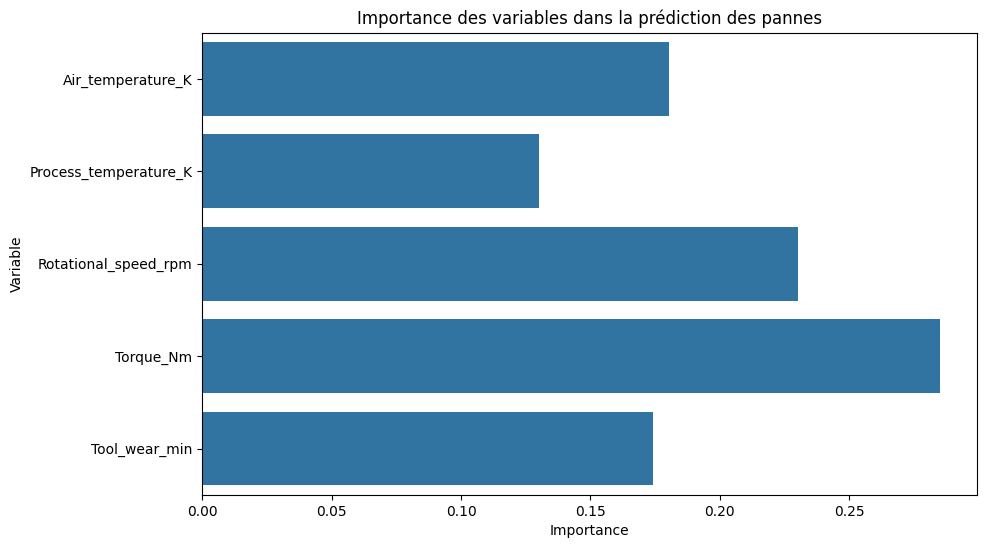

In [ ]:


# Importance des features
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=model_xgb.feature_importances_, y=feature_names)
plt.title('Importance des variables dans la prédiction des pannes')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.savefig('importance_variables.png')
plt.show()

In [ ]:
# import streamlit as st
# import pandas as pd
# import joblib

# # Charger le modèle et le scaler
# model = joblib.load('model_rf.pkl')
# scaler = joblib.load('scaler.pkl')

# # Interface Streamlit
# st.title("Maintenance Prédictive pour Équipements Agricoles")
# st.write("Entrez les données de l'équipement pour prédire le risque de panne.")

# # Entrées utilisateur
# air_temp = st.number_input("Température de l'air [K]", min_value=0.0, value=300.0)
# process_temp = st.number_input("Température du processus [K]", min_value=0.0, value=310.0)
# rpm = st.number_input("Vitesse de rotation [rpm]", min_value=0.0, value=1500.0)
# torque = st.number_input("Couple [Nm]", min_value=0.0, value=40.0)
# tool_wear = st.number_input("Usure de l'outil [min]", min_value=0.0, value=100.0)
# product_quality = st.selectbox("Qualité du produit", ['L', 'M', 'H'])

# # Préparer les données
# new_data = pd.DataFrame({
#     'air temperature [K]': [air_temp],
#     'process temperature [K]': [process_temp],
#     'rotational speed [rpm]': [rpm],
#     'torque [Nm]': [torque],
#     'tool wear [min]': [tool_wear],
#     'product_quality': [product_quality]
# })

# # Encoder la qualité du produit
# new_data = pd.get_dummies(new_data, columns=['product_quality'], drop_first=True)
# # Ajouter les colonnes manquantes (si product_quality_L ou H n'est pas présent)
# for col in ['product_quality_M', 'product_quality_H']:
#     if col not in new_data.columns:
#         new_data[col] = 0

# # Réorganiser les colonnes pour correspondre à l'entraînement
# new_data = new_data[X.columns]
# new_data_scaled = scaler.transform(new_data)

# # Prédiction
# if st.button("Prédire"):
#     proba = model.predict_proba(new_data_scaled)[:, 1][0]
#     st.write(f"Probabilité de panne dans les 30 jours : **{proba:.2%}**")
#     if proba > 0.5:
#         st.warning("Risque élevé de panne ! Planifiez une maintenance.")
#     else:
#         st.success("Risque faible. Continuez à surveiller.")